# 探究完全相同16S之间BGC分布的一致性

In [10]:
from pathlib import Path

table = Path("data/TableS1_HQ_filtered16S.csv")

In [11]:
import pandas as pd

table_df = pd.read_csv(table)
table_df

,assembly_accession,CheckM completeness,CheckM contamination,16S_ID,assembly_level,Sum,PKSI,PKSother,NRPS,RiPPs,Saccharides,Terpene,PKS-NRP_Hybrids,Others
0,GCF_000022305.1,100.0,0.67,refseq4905,Complete Genome,3,0,0,0,0,0,1,0,2
1,GCF_000025965.1,100.0,0.37,refseq15376,Complete Genome,7,0,0,0,0,0,1,0,6
2,GCF_000023105.1,100.0,0.84,refseq45559,Complete Genome,1,0,0,0,0,0,1,0,0
3,GCF_000012365.1,100.0,0.06,refseq128457,Complete Genome,20,1,0,5,3,0,2,2,7
4,GCF_000024165.1,100.0,0.88,refseq35003,Complete Genome,8,0,0,2,1,0,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175316,GCF_006346995.1,90.0,0.20,refseq49,Contig,1,0,0,0,0,0,0,0,1
175317,GCF_011612125.1,90.0,4.00,refseq12553,Complete Genome,3,0,0,0,1,0,1,0,1
175318,GCF_017355305.1,90.0,4.69,refseq3002,Contig,7,0,0,1,0,0,1,0,5
175319,GCF_018334415.1,90.0,2.97,refseq112011,Contig,4,0,0,0,1,0,0,0,3


In [12]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from itertools import combinations


def replace_zero_rows(df):
    # 需要修改的列（除了 Std）
    stat_cols = ["Mean", "Max", "Min", "Median", "Q25", "Q75"]

    # 识别所有这些列都为 0 的行
    zero_rows = (df[stat_cols + ["Std"]] == 0).all(axis=1)

    # 将这些行的除 Std 外的列替换为 1
    df.loc[zero_rows, stat_cols] = 1.0

    return df

def bgc_smi_in_same_16S(df):
    bgc_vector_cols = df.columns[-8:]
    # 准备输出结果
    sim_stat_dict = {}
    # 按照 16S_ID 分组
    for group_id, group_df in df.groupby('16S_ID'):
        vectors = group_df[bgc_vector_cols].values

        # 如果组内小于两个样本，就跳过（无法比较）
        if len(vectors) < 2:
            continue
        # 计算组内所有 BGC 向量之间的相似度（余弦相似度矩阵）
        sim_matrix = cosine_similarity(vectors)

        pairwise_sims = [sim_matrix[i][j] for i, j in combinations(range(len(vectors)), 2)]

        sims = np.array(pairwise_sims)
        stats = {
            "Mean": sims.mean(),
            "Max": sims.max(),
            "Min": sims.min(),
            "Std": sims.std(),
            "Median": np.median(sims),
            "Q25": np.percentile(sims, 25),
            "Q75": np.percentile(sims, 75),
        }

        sim_stat_dict[group_id] = stats
    # 将结果转换为 DataFrame
    sim_stat_df = pd.DataFrame.from_dict(sim_stat_dict, orient='index')
    sim_stat_df.index.name = "16S_ID"
    sim_stat_df = replace_zero_rows(sim_stat_df)
    return sim_stat_df
    

In [13]:
sim_stat_df = bgc_smi_in_same_16S(table_df)

In [14]:
sim_stat_df

,Mean,Max,Min,Std,Median,Q25,Q75
16S_ID,,,,,,,
refseq1,0.935324,1.000000,0.000000,0.080353,0.953463,0.912871,1.000000
refseq10,0.992577,1.000000,0.948683,0.009875,0.997054,0.989949,1.000000
refseq100,0.839551,1.000000,0.000000,0.145937,0.866025,0.816497,0.942809
refseq1000,0.973187,1.000000,0.602464,0.049953,0.992278,0.975900,1.000000
refseq10001,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...
refseq9979,0.849858,1.000000,0.774597,0.094545,0.792594,0.779096,0.921721
refseq998,0.901131,1.000000,0.670820,0.073868,0.912871,0.866025,0.952579
refseq9993,0.953499,1.000000,0.903696,0.041810,0.973124,0.903906,0.993281


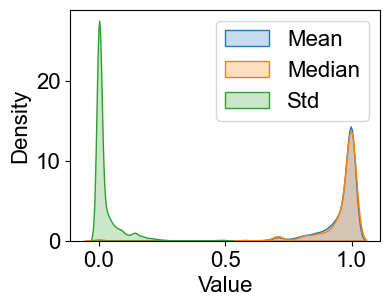

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# 密度图（KDE）
plt.figure(figsize=(4, 3))
sns.kdeplot(sim_stat_df["Mean"], label="Mean", fill=True)
sns.kdeplot(sim_stat_df["Median"], label="Median", fill=True)
sns.kdeplot(sim_stat_df["Std"], label="Std", fill=True)
plt.legend()
# plt.title("Distribution of Group Similarity Statistics")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()
    

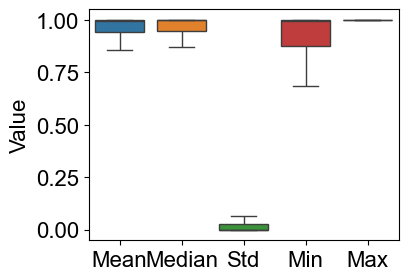

In [16]:
# 箱线图（对比多个统计量）
plt.figure(figsize=(4, 3))
sns.boxplot(data=sim_stat_df[["Mean", "Median", "Std", "Min", "Max"]], fliersize=0)
# plt.title("Distribution of Similarity Statistics Across 16S_ID Groups")
plt.ylabel("Value")
plt.show()


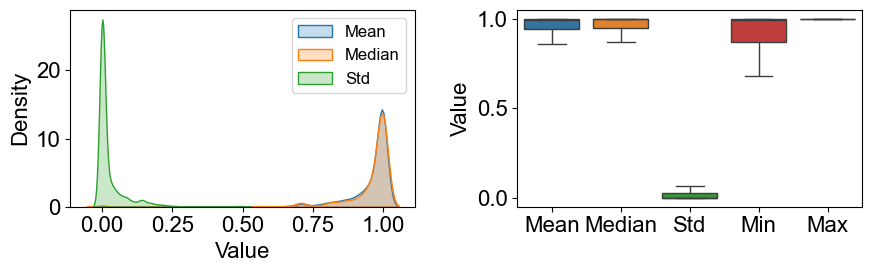

In [17]:
# 设置全局字体大小
plt.rcParams.update({'font.size': 16,
                     'font.family': 'sans-serif',
                     'font.sans-serif': ['Arial'],
                     })

# 创建一个包含 1 行 2 列子图的画布
fig, axes = plt.subplots(1, 2, figsize=(9, 3))

# 在第一个子图中绘制密度图（KDE）
sns.kdeplot(sim_stat_df["Mean"], label="Mean", fill=True, ax=axes[0])
sns.kdeplot(sim_stat_df["Median"], label="Median", fill=True, ax=axes[0])
sns.kdeplot(sim_stat_df["Std"], label="Std", fill=True, ax=axes[0])
axes[0].legend(fontsize=12)
axes[0].set_xlabel("Value")
axes[0].set_ylabel("Density")

# 在第二个子图中绘制箱线图（对比多个统计量）
sns.boxplot(data=sim_stat_df[["Mean", "Median", "Std", "Min", "Max"]], fliersize=0, ax=axes[1])
axes[1].set_ylabel("Value")

# 调整子图之间的间距
plt.tight_layout()

plt.savefig("analysis/correlation(Fig3)/BGC_similarity_in_cdhit_cluster/plot/boxplot_density.png", dpi=300, bbox_inches='tight')

# 显示图形
plt.show()
    

In [18]:
import numpy as np

vectors = np.array([[2, 3, 1, 0, 1, 2, 1, 5],
                    [2, 3, 1, 0, 1, 2, 1, 5],
                    [2, 3, 1, 0, 1, 2, 1, 2]])

def cosine_similarity_matrix(vectors):
    dot_product = np.dot(vectors, vectors.T)
    norm = np.linalg.norm(vectors, axis = 1).reshape(-1, 1)
    norm_product = np.dot(norm, norm.T)
    return dot_product / norm_product

similarity_matrix = cosine_similarity_matrix(vectors)
print(similarity_matrix)


[[1.         1.         0.91287093]
 [1.         1.         0.91287093]
 [0.91287093 0.91287093 1.        ]]
